In [1]:
# Import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = 16

In [2]:
# Load data from database
df = pd.read_sql_table('disaster_data', 'sqlite:///../data/DisasterResponse.db')  

In [3]:
# Glance at the data
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,True,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Null values
(df.isna().sum()*100 / len(df["id"])).sort_values(ascending=False)

original                  61.206897
id                         0.000000
aid_centers                0.000000
infrastructure_related     0.000000
transport                  0.000000
buildings                  0.000000
electricity                0.000000
tools                      0.000000
hospitals                  0.000000
shops                      0.000000
other_infrastructure       0.000000
death                      0.000000
weather_related            0.000000
floods                     0.000000
storm                      0.000000
fire                       0.000000
earthquake                 0.000000
cold                       0.000000
other_weather              0.000000
other_aid                  0.000000
refugees                   0.000000
message                    0.000000
search_and_rescue          0.000000
genre                      0.000000
related                    0.000000
request                    0.000000
offer                      0.000000
aid_related                0

Only 'original' has null values which is Ok, we only care about 'messages'

In [5]:
# Category sum
category_percentage_true = df.drop(["message", "id", "original", "genre"], axis=1).sum() / len(df["id"])
(category_percentage_true*100).sort_values()

child_alone                0.000000
offer                      0.450107
shops                      0.457736
tools                      0.606500
fire                       1.075679
hospitals                  1.079493
missing_people             1.136710
aid_centers                1.178670
clothing                   1.544858
security                   1.796613
cold                       2.021666
electricity                2.029295
money                      2.303937
search_and_rescue          2.761672
military                   3.280439
refugees                   3.337656
other_infrastructure       4.390449
death                      4.554471
transport                  4.581172
medical_products           5.008392
buildings                  5.084681
other_weather              5.248703
water                      6.377785
infrastructure_related     6.503662
medical_help               7.949344
floods                     8.220171
shelter                    8.826671
storm                      9

'child_alone' has no true values. There are also quite a number of categories with low percentage (<2%) of examples. Without enough examples, our model will not be able to categorize messages into these categories accurately.

In [7]:
def tokenize(text):
    """
    Clean and tokenize a text input
    Input:
        text: Input text
    Output:
        clean_tokens: Cleaned and tokenized text
    """
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

    # Unify URLs with a placeholder
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
        
    # Split text into words
    tokens = word_tokenize(text)
    
    # Group inflected words, remove whitespace, transform all to lowercase
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(x).lower().strip() for x in tokens]
    
    return clean_tokens

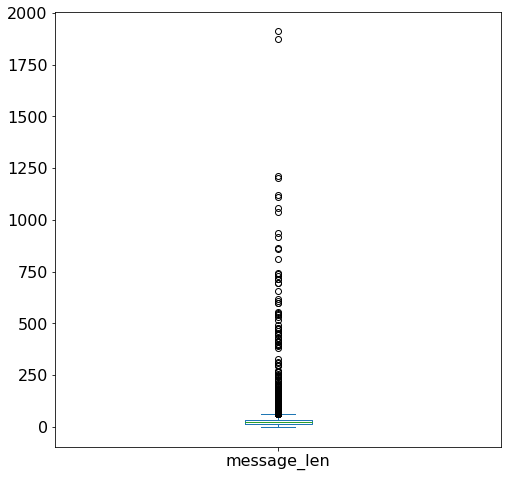

In [8]:
# Message length outliers
df["message_len"] = df["message"].apply(lambda x: len(tokenize(x)))
df["message_len"].plot(kind="box");

Message length has quite a few outliers.

In [9]:
def tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]

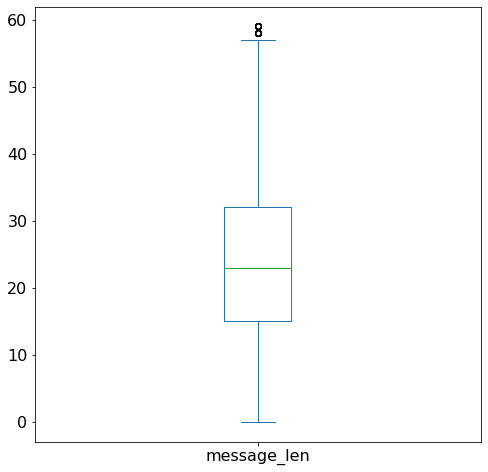

In [10]:
remove_outlier_df = tukey_rule(df, "message_len")
remove_outlier_df["message_len"].plot(kind="box");

In [15]:
print("Number of outliers:", len(df["id"]) - len(remove_outlier_df["id"]))

Number of outliers: 633


In [16]:
# Unique words
df["tokens"] = df["message"].apply(lambda x: tokenize(x))

In [25]:
all_words = []
for row in df.iterrows():
    all_words += row[1]["tokens"]

In [31]:
print("Total number of words:", len(all_words))

Total number of words: 706432


In [30]:
print("Total number of unique words:", len(np.unique(all_words)))

Total number of unique words: 36983
